In [1]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
# tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

2018-09-11
5.8.6


In [68]:
from rasterio import features, Affine, float64, int16, int32
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

In [91]:
import colorcet
kbc = colorcet.cm.kbc
inferno = colorcet.cm.bmy

In [4]:
from SE.spatial import get_better_boundaries, NYC_CRS, MERCATOR_CRS
nyc = get_better_boundaries(area_type='city', nyc_crs=True)

In [5]:
bronx = get_better_boundaries(area_type='borough', nyc_crs=True)
bronx = bronx[bronx.name == 'Bronx'].iloc[0]

In [6]:
bronx

id                                                         306
Borough                                                  Bronx
area_id                                                    200
area_type                                              borough
name                                                     Bronx
geometry     POLYGON ((1002729.278177822 241005.3041398225,...
Name: 306, dtype: object

In [7]:
cb = pd.read_pickle('../data/correct_geom.pkl')

In [8]:
bronx_cv = cb[cb.centroid.within(bronx.geometry)]

In [9]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [10]:
E = bronx['geometry'].envelope.buffer(10).envelope
print(E)

POLYGON ((1002598.146822902 228939.5558932023, 1045779.897962803 228939.5558932023, 1045779.897962803 273111.589647286, 1002598.146822902 273111.589647286, 1002598.146822902 228939.5558932023))


In [11]:
cvs = ds.Canvas(plot_height=1000,
                plot_width=1000,
                x_range=(1002598, 1045779),
                y_range=(228939, 273111))

aform = get_transform(cvs)
aform

Affine(43.181, 0.0, 1002598.0,
       0.0, -44.172, 273111.0)

## Overal

In [82]:
border = features.rasterize([bronx.geometry.boundary], 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

In [83]:
bd.sum()

<xarray.DataArray ()>
array(5777.)

In [110]:
F = features.rasterize([(el, 1) for el in bronx_cv['geometry'].tolist()], 
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

In [111]:
df = DataArray(data=pd.np.flipud(F))

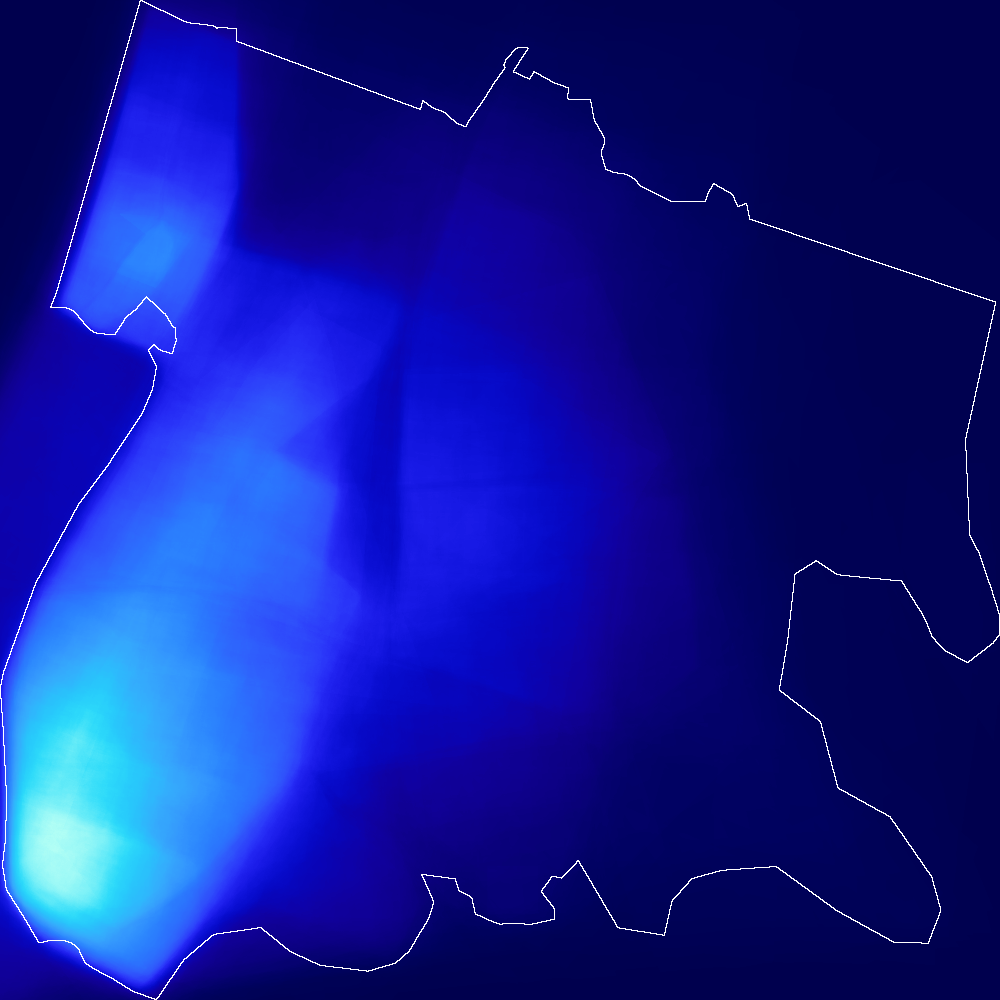

In [112]:
tf.stack(tf.shade(df, how='linear', cmap=kbc, name='Density'), 
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

# Split by year

In [131]:
D = {}
for Y in (2015,2016,2017,2018):
    df = bronx_cv[bronx_cv.created_at.dt.year == Y]
    
    F = features.rasterize([(el, 1) for el in df['geometry'].tolist()], 
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)
    
    raster = DataArray(data=pd.np.flipud(F))
    I = tf.Image(tf.stack(tf.shade(raster, how='linear', cmap=inferno), 
                          tf.shade(bd, how='eq_hist', cmap=['black','white'])), name=k)
    D[Y] = I

In [134]:
I = D[2015]

In [135]:
for Y, v in D.items():
    v.to_pil().save(f"../img/bronx/bronx_{Y}.png")

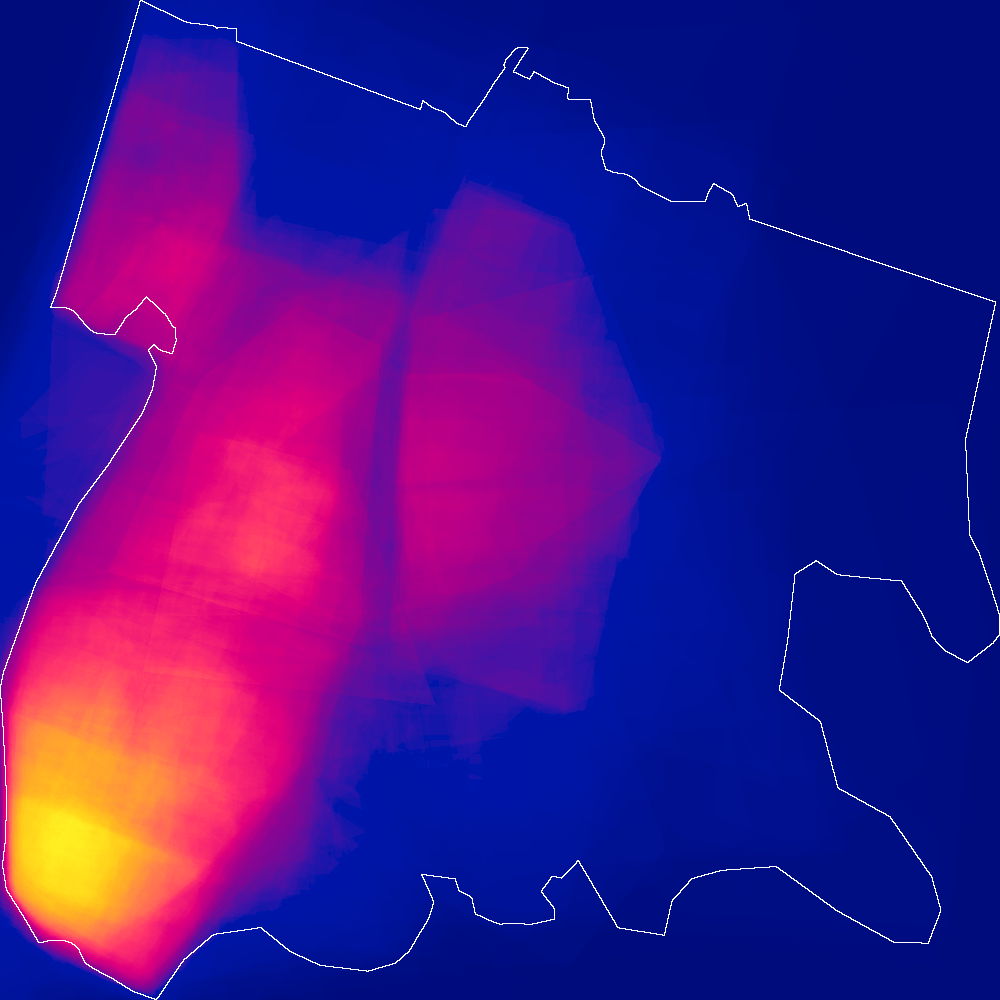

In [133]:
D[2016]